In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import graphviz as gr

import seaborn as sns

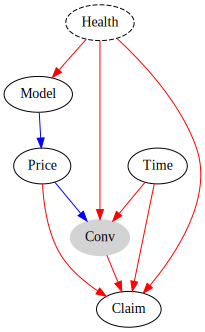

In [2]:
cop_dag = gr.Digraph()

cop_dag.edge("Health", "Model", color="red")
cop_dag.edge("Model", "Price", color="blue")
cop_dag.edge("Price", "Conv", color="blue")
cop_dag.edge("Health", "Conv", color="red")

cop_dag.edge("Time", "Conv", color="red")
cop_dag.edge("Time", "Claim", color="red")

cop_dag.edge("Health", "Claim", color="red")
cop_dag.edge("Conv", "Claim", color="red")
cop_dag.edge("Price", "Claim", color="red")

cop_dag.node("Conv", color="lightgrey", style="filled")
cop_dag.node("Health", style="dashed")

cop_dag

In [3]:
price_assignment = pd.DataFrame(dict(
    price = [20,40,60,80,   20,40,60,80, 20,40,60,80, 20,40,60,80],
    ps =    [.4,.3,.2,.1,  .3,.3,.2,.2, .2,.2,.3,.3, .1,.2,.3,.4,],
    model = [1,1,1,1,       2,2,2,2,     3,3,3,3,     4,4,4,4,]
)).set_index("model")

In [4]:
n = 100000

np.random.seed(123)

health = np.random.beta(2,2, n)*11
model = (np.round(np.random.beta(health/health.mean(), 1)*3)+1).astype(int)
time = np.random.randint(1, 13, n)

price = np.array([np.random.choice(price_assignment.loc[m]["price"], p=price_assignment.loc[m]["ps"])
                  for m in model])

def conv_fn(p):
    return ((-0.05*p + health + time) > 5)*1


def claim_fn(p):
    return ((health + 0.1*p + 0.5*time) > 12)*1


conv = conv_fn(price)
claim = claim_fn(price)

df_cop = pd.DataFrame(dict(
    health=health,
    time=time,
    price=price,
    conv=conv,
    model=model,
    claim=claim*conv,
    **{**{f"conv_{p}": conv_fn(p) for p in np.unique(price)}}
))


df_cop = (df_cop
          .assign(**{f"claim_{p}": df_cop[f"conv_{p}"]*claim_fn(p) for p in np.unique(price)})
          .merge(price_assignment.reset_index(), on=["price", "model"]))

print(df_cop.mean())
df_cop.head()

health       5.503251
time         6.503860
price       49.468200
conv         0.838120
model        2.414050
claim        0.605680
conv_20      0.915040
conv_40      0.867930
conv_60      0.809580
conv_80      0.741680
claim_20     0.350760
claim_40     0.592320
claim_60     0.774160
claim_80     0.741680
ps           0.275542
dtype: float64


,health,time,price,conv,model,claim,conv_20,conv_40,conv_60,conv_80,claim_20,claim_40,claim_60,claim_80,ps
0,1.736504,3,60,0,1,0,0,0,0,0,0,0,0,0,0.2
1,2.991294,12,60,1,1,1,1,1,1,1,0,1,1,1,0.2
2,2.492579,9,60,1,1,1,1,1,1,1,0,0,1,1,0.2
3,2.000869,10,60,1,1,1,1,1,1,1,0,0,1,1,0.2
4,1.968288,2,60,0,1,0,0,0,0,0,0,0,0,0,0.2


In [5]:
df_cop.query("price==40")

,health,time,price,conv,model,claim,conv_20,conv_40,conv_60,conv_80,claim_20,claim_40,claim_60,claim_80,ps
52913,10.719150,10,40,1,4,1,1,1,1,1,1,1,1,1,0.2
52914,2.699107,2,40,0,4,0,0,0,0,0,0,0,0,0,0.2
52915,3.872851,9,40,1,4,1,1,1,1,1,0,1,1,1,0.2
52916,7.134701,3,40,1,4,1,1,1,1,1,0,1,1,1,0.2
52917,6.146034,2,40,1,4,0,1,1,1,0,0,0,1,0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.934520,1,40,0,1,0,0,0,0,0,0,0,0,0,0.3
99996,7.061395,2,40,1,1,1,1,1,1,1,0,1,1,1,0.3
99997,4.334269,8,40,1,1,1,1,1,1,1,0,1,1,1,0.3
99998,5.042518,2,40,1,1,0,1,1,0,0,0,0,0,0,0.3


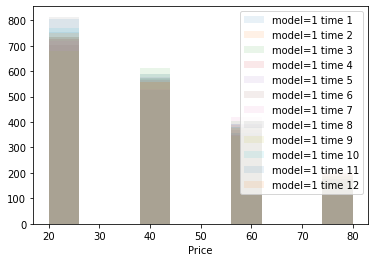

In [6]:
[plt.hist(df_cop.query(f"model==1").query(f"time=={t}")["price"], alpha=0.1, label=f"model=1 time {t}") for t in range(1,13)]
plt.xlabel("Price")
plt.legend();

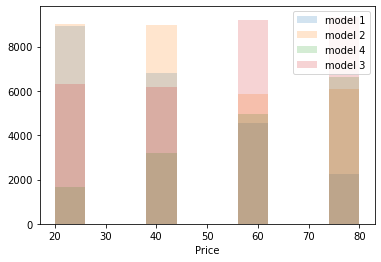

In [7]:
[plt.hist(df_cop.query(f"model=={m}")["price"], alpha=0.2, label=f"model {m}") for m in df_cop["model"].unique()]
plt.xlabel("Price")
plt.legend();

## Adjusting for Confounders

### IPW

$$
\begin{align}
\tau &= E\bigg[\dfrac{1(T=1)Y}{e(x)} \bigg] - E\bigg[\dfrac{1(T=0)Y}{1-e(x)} \bigg]\\
&=E\bigg[Y\dfrac{1(T=1)(1-e(x)) - 1(T=0)e(x)}{e(x)(1-e(x))} \bigg] \\
&=E\bigg[Y\dfrac{T(1-e(x)) - (1-T)e(x)}{e(x)(1-e(x))} \bigg] \\
&=E\bigg[Y\dfrac{T-Te(x) - e(x) + Te(x)}{e(x)(1-e(x))} \bigg] \\
&=E\bigg[Y\dfrac{T- e(x)}{e(x)(1-e(x))} \bigg] \\
\end{align}
$$


### OLS

$$
\begin{align}
\tau &= \bigg[\dfrac{Y(T - E[T|X])}{(T - E[T|X])^2}\bigg] \\
&= \bigg[\dfrac{Y(T - E[T|X])}{(T - E[T|X])^2}\bigg] \\
\end{align}
$$

In [8]:
def estimate_ps(df, x=["model"], t="price"):
     ps_dataset = (df
                  .groupby(x+[t])
                  .size()
                  .reset_index()
                  .assign(
                      ps_est = lambda d: d[0]/d.groupby(x)[0].transform("sum"),
                  )
                  .assign(w_est = lambda d: 1/d["ps_est"])
                  [x+[t, "w_est", "ps_est"]])
    
     return (df
             .merge(ps_dataset, on=x+[t]))

    
def orthogonalize(df, x=["model"], t="price"):
    mu = df[t].mean()
    return (
        df.assign(**{
            t+"_deb":  mu + df[t] - df.groupby(x)[t].transform("mean")
        })
    )

    
    
def estimate_factual_curve(df, y, x=["model", "time"], t="price", weight="w"):

    return (df
            .groupby(t)
            .apply(lambda d: np.average(d[y], weights=d[weight])))

## Effect of Price on Conversion

### Biased

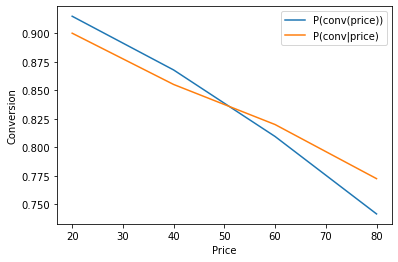

In [9]:
cf_conv_curve = (df_cop[[f"conv_{p}" for p in df_cop["price"].unique()]]
                 .melt()
                 .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                 .groupby(["price"])[["value"]].mean())

factual_conv_curve = (df_cop
                      .groupby("price")
                      .apply(lambda d: np.average(d["conv"])))

plt.plot(cf_conv_curve, label="P(conv(price))")
plt.plot(factual_conv_curve, label="P(conv|price)")

plt.ylabel("Conversion")
plt.xlabel("Price")
plt.legend();

### Using IPW

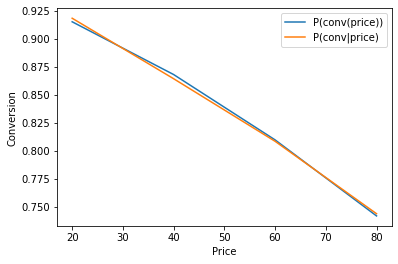

In [10]:
cf_conv_curve = (df_cop[[f"conv_{p}" for p in df_cop["price"].unique()]]
                 .melt()
                 .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                 .groupby(["price"])[["value"]].mean())

factual_conv_curve = (df_cop.assign(w=lambda d: 1/d["ps"])
                      .groupby("price")
                      .apply(lambda d: np.average(d["conv"], weights=d["w"])))

plt.plot(cf_conv_curve, label="P(conv(price))")
plt.plot(factual_conv_curve, label="P(conv|price)")

plt.ylabel("Conversion")
plt.xlabel("Price")
plt.legend();

### Using Orthogonalization

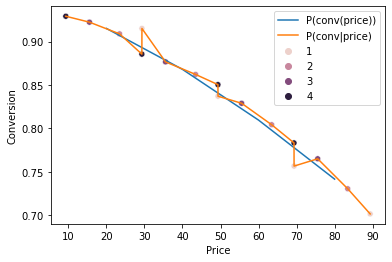

In [11]:
cf_conv_curve = (df_cop[[f"conv_{p}" for p in df_cop["price"].unique()]]
                 .melt()
                 .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                 .groupby(["price"])[["value"]].mean())

ortho_df = orthogonalize(orthogonalize(df_cop, x=["model"], t="price"), x=["model"], t="conv")

factual_conv_curve = (ortho_df
                      .groupby("price_deb")
                      .apply(lambda d: np.average(d["conv_deb"])))

plt.plot(cf_conv_curve, label="P(conv(price))")
plt.plot(factual_conv_curve, label="P(conv|price)")

sns.scatterplot(data=(ortho_df
                      .groupby(["price_deb", "model"])["conv_deb"]
                      .mean().reset_index()),
                x="price_deb", y="conv_deb", hue="model")

plt.ylabel("Conversion")
plt.xlabel("Price")
plt.legend();

## Effect of Price on Claims

### Biased

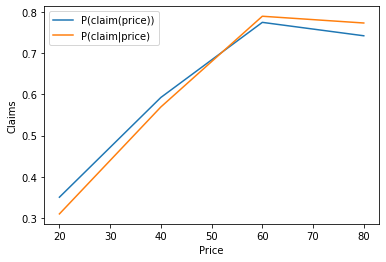

In [12]:
cf_claim_curve = (df_cop[[f"claim_{p}" for p in df_cop["price"].unique()]]
                 .melt()
                 .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                 .groupby(["price"])[["value"]].mean())

factual_claim_curve = (df_cop
                      .groupby("price")
                      .apply(lambda d: np.average(d["claim"])))

plt.plot(cf_claim_curve, label="P(claim(price))")
plt.plot(factual_claim_curve, label="P(claim|price)")

plt.ylabel("Claims")
plt.xlabel("Price")
plt.legend();

### Using IPW

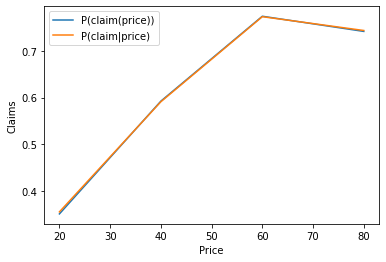

In [13]:
cf_claim_curve = (df_cop[[f"claim_{p}" for p in df_cop["price"].unique()]]
                 .melt()
                 .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                 .groupby(["price"])[["value"]].mean())

factual_claim_curve = (df_cop
                      .groupby("price")
                      .apply(lambda d: np.average(d["claim"],  weights=1/d["ps"])))

plt.plot(cf_claim_curve, label="P(claim(price))")
plt.plot(factual_claim_curve, label="P(claim|price)")

plt.ylabel("Claims")
plt.xlabel("Price")
plt.legend();

### Using Orthogonalization

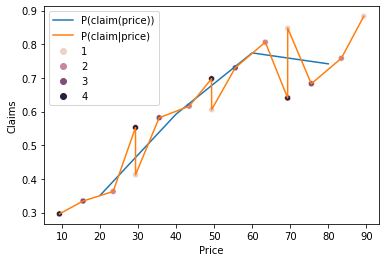

In [14]:
cf_claim_curve = (df_cop[[f"claim_{p}" for p in df_cop["price"].unique()]]
                 .melt()
                 .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                 .groupby(["price"])[["value"]].mean())

ortho_df = orthogonalize(orthogonalize(df_cop, x=["model"], t="price"), x=["model"], t="claim")

factual_claim_curve = (ortho_df
                      .groupby("price_deb")
                      .apply(lambda d: np.average(d["claim_deb"])))

plt.plot(cf_claim_curve, label="P(claim(price))")
plt.plot(factual_claim_curve, label="P(claim|price)")

sns.scatterplot(data=(ortho_df
                      .groupby(["price_deb", "model"])["claim_deb"]
                      .mean().reset_index()),
                x="price_deb", y="claim_deb", hue="model")

plt.ylabel("Claims")
plt.xlabel("Price")
plt.legend();

## Effect on Converted 

### IPW

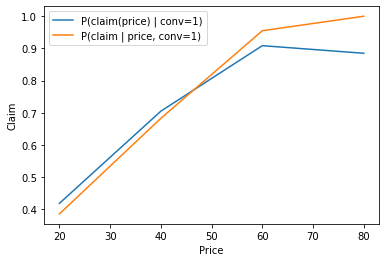

In [15]:
cf_claim_curve_conv = (df_cop
                      .query("conv==1")
                      [[f"claim_{p}" for p in df_cop["price"].unique()]]
                      .melt()
                      .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                      .groupby(["price"])[["value"]].mean())

factual_claim_curve = estimate_factual_curve(estimate_ps(df_cop.query("conv==1"), x=["model"], t="price"),
                                            "claim", x=["model"], weight="w_est")

plt.plot(cf_claim_curve_conv, label="P(claim(price) | conv=1)")
plt.plot(factual_claim_curve, label="P(claim | price, conv=1)")
plt.legend()
plt.ylabel("Claim")
plt.xlabel("Price");

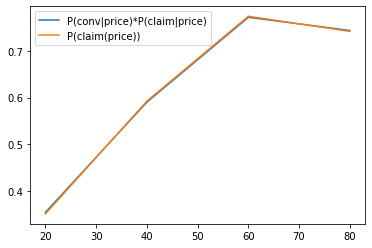

In [16]:
factual_conv_curve = (df_cop
                      .groupby("price")
                      .apply(lambda d: np.average(d["conv"], weights=1/d["ps"])))

plt.plot(pd.DataFrame(factual_conv_curve.values*factual_claim_curve.values, index=factual_claim_curve.index),
         label="P(conv|price)*P(claim|price)")
plt.plot(cf_claim_curve, label="P(claim(price))")
plt.legend();

#### Not Estimating the Weights

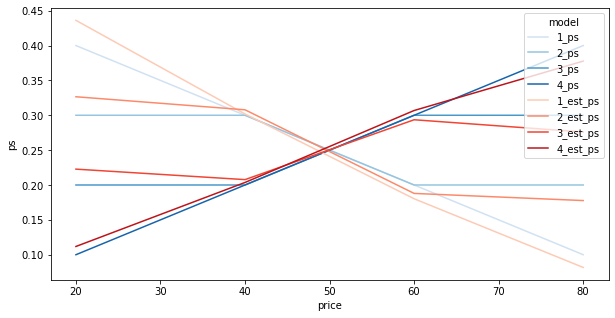

In [17]:
df_plt = (df_cop
 .query("conv==1")
 .assign(size=1)
 .groupby(["model", "price"])
 .agg({"size": "sum", "ps":"mean"})
 .reset_index()
 .assign(est_ps = lambda d: d["size"]/d.groupby("model")["size"].transform("sum"))
)

plt.figure(figsize=(10,5))
sns.lineplot(data=df_plt.assign(model = lambda d: d["model"].astype(str)+"_ps"),
             y="ps", x="price", hue="model", palette="Blues")

sns.lineplot(data=df_plt.assign(model = lambda d: d["model"].astype(str)+"_est_ps"),
             y="est_ps", x="price", hue="model", palette="Reds");

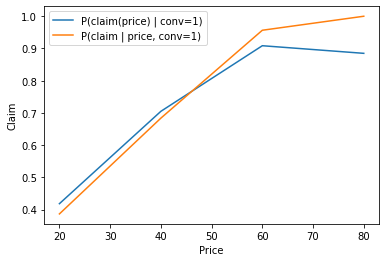

In [18]:
cf_claim_curve_conv = (df_cop
                      .query("conv==1")
                      [[f"claim_{p}" for p in df_cop["price"].unique()]]
                      .melt()
                      .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                      .groupby(["price"])[["value"]].mean())

factual_claim_curve = (df_cop
                       .query("conv==1")
                      .groupby("price")
                      .apply(lambda d: np.average(d["claim"],  weights=1/d["ps"])))

plt.plot(cf_claim_curve_conv, label="P(claim(price) | conv=1)")
plt.plot(factual_claim_curve, label="P(claim | price, conv=1)")
plt.legend()
plt.ylabel("Claim")
plt.xlabel("Price");

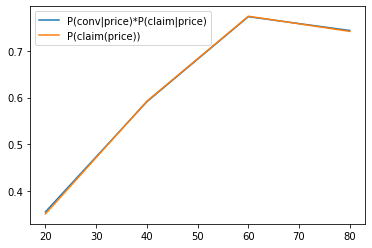

In [19]:
factual_conv_curve = (df_cop
                      .groupby("price")
                      .apply(lambda d: np.average(d["conv"], weights=1/d["ps"])))

plt.plot(pd.DataFrame(factual_conv_curve.values*factual_claim_curve.values, index=factual_claim_curve.index),
         label="P(conv|price)*P(claim|price)")
plt.plot(cf_claim_curve, label="P(claim(price))")
plt.legend();

### Orthogonalization

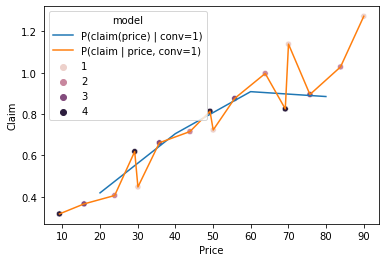

In [20]:
cf_claim_curve_conv = (df_cop
                      .query("conv==1")
                      [[f"claim_{p}" for p in df_cop["price"].unique()]]
                      .melt()
                      .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                      .groupby(["price"])[["value"]].mean())


ortho_df = orthogonalize(orthogonalize(df_cop.query("conv==1"), x=["model"], t="price"), x=["model"], t="claim")

factual_claim_curve = (ortho_df
                       .groupby("price_deb")
                       .apply(lambda d: np.average(d["claim_deb"])))

plt.plot(cf_claim_curve_conv, label="P(claim(price) | conv=1)")
plt.plot(factual_claim_curve, label="P(claim | price, conv=1)")
plt.legend()

sns.scatterplot(data=(ortho_df
                      .groupby(["price_deb", "model"])["claim_deb"]
                      .mean().reset_index()),
                x="price_deb", y="claim_deb", hue="model")

plt.ylabel("Claim")
plt.xlabel("Price");

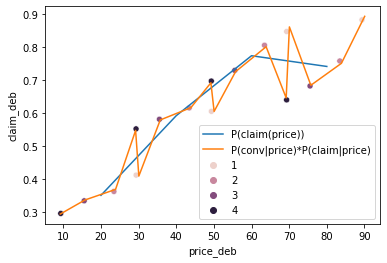

In [21]:
factual_conv_curve = (orthogonalize(orthogonalize(df_cop, x=["model"], t="price"), x=["model"], t="conv")
                      .groupby("price_deb")
                      .apply(lambda d: np.average(d["conv_deb"])))


plt.plot(cf_claim_curve, label="P(claim(price))")
plt.plot(pd.DataFrame(factual_conv_curve.values*factual_claim_curve.values, index=factual_claim_curve.index),
         label="P(conv|price)*P(claim|price)")


ortho_df = orthogonalize(orthogonalize(df_cop, x=["model"], t="price"), x=["model"], t="claim")
sns.scatterplot(data=(ortho_df
                      .groupby(["price_deb", "model"])["claim_deb"]
                      .mean().reset_index()),
                x="price_deb", y="claim_deb", hue="model")

plt.legend();

#### Not Estimating the E[T|X, conv=1]

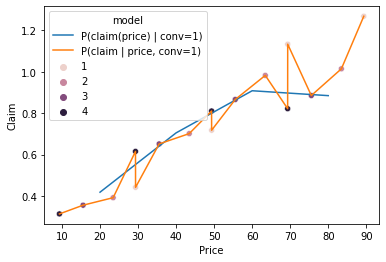

In [22]:
cf_claim_curve_conv = (df_cop
                      .query("conv==1")
                      [[f"claim_{p}" for p in df_cop["price"].unique()]]
                      .melt()
                      .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                      .groupby(["price"])[["value"]].mean())


ortho_df = orthogonalize(orthogonalize(df_cop, x=["model"], t="price"), x=["model"], t="claim").query("conv==1")

factual_claim_curve = (ortho_df
                       .groupby("price_deb")
                       .apply(lambda d: np.average(d["claim_deb"])))

plt.plot(cf_claim_curve_conv, label="P(claim(price) | conv=1)")
plt.plot(factual_claim_curve, label="P(claim | price, conv=1)")
plt.legend()

sns.scatterplot(data=(ortho_df
                      .groupby(["price_deb", "model"])["claim_deb"]
                      .mean().reset_index()),
                x="price_deb", y="claim_deb", hue="model")

plt.ylabel("Claim")
plt.xlabel("Price");

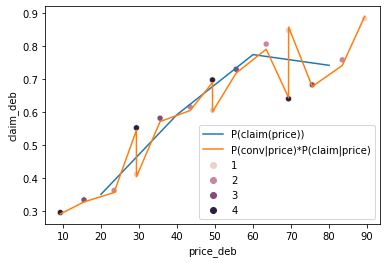

In [23]:
factual_conv_curve = (orthogonalize(orthogonalize(df_cop, x=["model"], t="price"), x=["model"], t="conv")
                      .groupby("price_deb")
                      .apply(lambda d: np.average(d["conv_deb"])))


plt.plot(cf_claim_curve, label="P(claim(price))")
plt.plot(pd.DataFrame(factual_conv_curve.values*factual_claim_curve.values, index=factual_claim_curve.index),
         label="P(conv|price)*P(claim|price)")


ortho_df = orthogonalize(orthogonalize(df_cop, x=["model"], t="price"), x=["model"], t="claim")
sns.scatterplot(data=(ortho_df
                      .groupby(["price_deb", "model"])["claim_deb"]
                      .mean().reset_index()),
                x="price_deb", y="claim_deb", hue="model")

plt.legend();

# Adding an Approve Rule

In [24]:
price_assignment = pd.DataFrame(dict(
    price = [20,40,60,80,   20,40,60,80, 20,40,60,80, 20,40,60,80],
    ps =    [.4,.3,.2,.1,  .3,.3,.2,.2, .2,.2,.3,.3, .1,.2,.3,.4,],
    model = [1,1,1,1,       2,2,2,2,     3,3,3,3,     4,4,4,4,]
)).set_index("model")


approval_rule = pd.DataFrame(dict(
    ps =    [.8,.6,.4,.2],
    model = [1,2,3,4]
)).set_index("model")

In [25]:
n = 100000

np.random.seed(123)

health = np.random.beta(2,2, n)*11
model = (np.round(np.random.beta(health/health.mean(), 1)*3)+1).astype(int)
time = np.random.randint(1, 13, n)

price = np.array([np.random.choice(price_assignment.loc[m]["price"], p=price_assignment.loc[m]["ps"])
                  for m in model])

appr_chance = approval_rule.loc[model].values.flatten()
approved = np.random.binomial(1, p=appr_chance)

def conv_fn(p):
    return ((-0.05*p + health + time) > 5)*1


def claim_fn(p):
    return ((health + 0.1*p + 0.5*time) > 12)*1


conv = conv_fn(price)
claim = claim_fn(price)

df_cop = pd.DataFrame(dict(
    health=health,
    time=time,
    price=price,
    conv=conv,
    approved_ps = appr_chance,
    approved=approved,
    model=model,
    claim=claim*conv*approved,
    **{**{f"conv_{p}": conv_fn(p) for p in np.unique(price)}}
))


df_cop = (df_cop
          .assign(**{f"claim_{p}_non_appr": df_cop[f"conv_{p}"]*claim_fn(p) for p in np.unique(price)})
          .assign(**{f"claim_{p}": df_cop[f"conv_{p}"]*claim_fn(p)*approved for p in np.unique(price)})
          .assign(**{"appr_w": 1/df_cop["approved_ps"]})
          .merge(price_assignment.reset_index(), on=["price", "model"]))

print(df_cop.mean())
df_cop.head()

health                5.503251
time                  6.503860
price                49.468200
conv                  0.838120
approved_ps           0.517190
approved              0.517070
model                 2.414050
claim                 0.281780
conv_20               0.915040
conv_40               0.867930
conv_60               0.809580
conv_80               0.741680
claim_20_non_appr     0.350760
claim_40_non_appr     0.592320
claim_60_non_appr     0.774160
claim_80_non_appr     0.741680
claim_20              0.157670
claim_40              0.279460
claim_60              0.381600
claim_80              0.368900
appr_w                2.379942
ps                    0.275542
dtype: float64


,health,time,price,conv,approved_ps,approved,model,claim,conv_20,conv_40,...,claim_20_non_appr,claim_40_non_appr,claim_60_non_appr,claim_80_non_appr,claim_20,claim_40,claim_60,claim_80,appr_w,ps
0,1.736504,3,60,0,0.8,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.25,0.2
1,2.991294,12,60,1,0.8,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1.25,0.2
2,2.492579,9,60,1,0.8,1,1,1,1,1,...,0,0,1,1,0,0,1,1,1.25,0.2
3,2.000869,10,60,1,0.8,0,1,0,1,1,...,0,0,1,1,0,0,0,0,1.25,0.2
4,1.968288,2,60,0,0.8,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.25,0.2


## Estimate Risk for Converted Non-Approved 

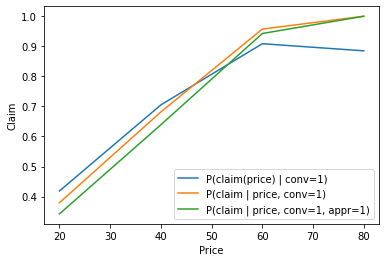

In [26]:
cf_claim_curve_conv = (df_cop
                      .query("conv==1")
                      [[f"claim_{p}_non_appr" for p in df_cop["price"].unique()]]
                      .melt()
                      .assign(price=lambda d: d["variable"].str.split("_").str[1].astype(int))
                      .groupby(["price"])[["value"]].mean())

factual_claim_curve_appr = (df_cop
                            .query("conv==1")
                            .query("approved==1")
                            .groupby("price")
                            .apply(lambda d: np.average(d["claim"],  weights=1/(d["ps"]))))

factual_claim_curve = (df_cop
                       .query("conv==1")
                       .query("approved==1")
                       .groupby("price")
                       .apply(lambda d: np.average(d["claim"],  weights=d["appr_w"]/(d["ps"]))))

plt.plot(cf_claim_curve_conv, label="P(claim(price) | conv=1)")
plt.plot(factual_claim_curve, label="P(claim | price, conv=1)")
plt.plot(factual_claim_curve_appr, label="P(claim | price, conv=1, appr=1)")
plt.legend()
plt.ylabel("Claim")
plt.xlabel("Price");

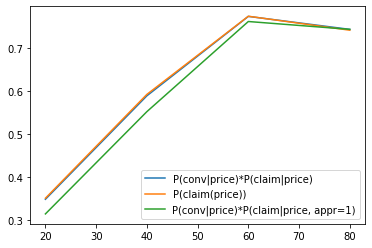

In [27]:
factual_conv_curve = (df_cop
                      .groupby("price")
                      .apply(lambda d: np.average(d["conv"], weights=1/d["ps"])))

plt.plot(pd.DataFrame(factual_conv_curve.values*factual_claim_curve.values, index=factual_claim_curve.index),
         label="P(conv|price)*P(claim|price)")

plt.plot(cf_claim_curve, label="P(claim(price))")

plt.plot(pd.DataFrame(factual_conv_curve.values*factual_claim_curve_appr.values, index=factual_claim_curve_appr.index),
         label="P(conv|price)*P(claim|price, appr=1)")
plt.legend();

In [66]:
n = 20000

possible_lines = [1000, 2000, 3000, 4000]

lines_ps = pd.DataFrame(dict(lusa = [1,1,1,1,      2,2,2,2,     3,3,3,3,     4,4,4,4],
                             ps =   [.0,.1,.2,.7, .1,.2,.3,.4, .4,.3,.2,.1, .7,.2,.1,.0])).set_index("lusa")


np.random.seed(123)

lusas = np.random.choice([1,2,3, 4], size=n)
lines = np.array([np.random.choice(possible_lines, p=lines_ps.loc[lusa].values.flatten()) for lusa in lusas])
spend = np.random.normal(0.9*lines - 500*lusas)

df = pd.DataFrame(dict(lusa = lusas, lines=lines, spend=spend))

df

,lusa,lines,spend
0,3,2000,299.970032
1,2,4000,2600.974724
2,3,3000,1202.090258
3,3,1000,-600.611310
4,1,3000,2200.610939
...,...,...,...
19995,3,1000,-599.246336
19996,4,3000,701.379035
19997,4,1000,-1099.082185
19998,2,4000,2601.263860


<AxesSubplot:xlabel='lines', ylabel='spend'>

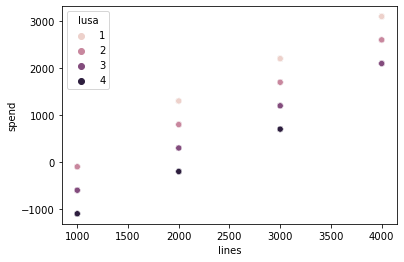

In [67]:
sns.scatterplot(data=df, x="lines", y="spend", hue="lusa")

<AxesSubplot:xlabel='lines_deb', ylabel='spend'>

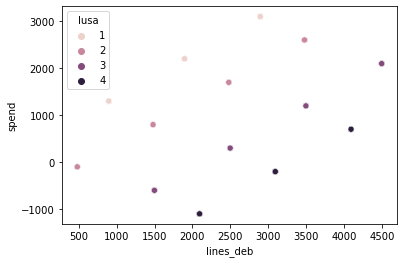

In [77]:
sns.scatterplot(data=df.assign(lines_deb = df["lines"].mean() + df["lines"] - df.groupby("lusa")["lines"].transform("mean"),
                               spend_deb = df["spend"].mean() + df["spend"] - df.groupby("lusa")["spend"].transform("mean")
                              ),
                x="lines_deb", y="spend", hue="lusa")

<AxesSubplot:xlabel='lines_deb', ylabel='spend_deb'>

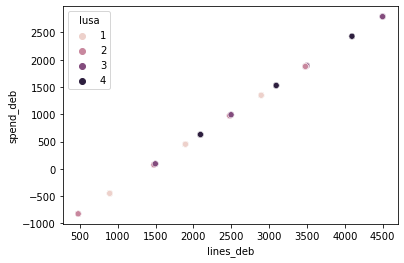

In [78]:
sns.scatterplot(data=df.assign(lines_deb = df["lines"].mean() + df["lines"] - df.groupby("lusa")["lines"].transform("mean"),
                               spend_deb = df["spend"].mean() + df["spend"] - df.groupby("lusa")["spend"].transform("mean")
                              ),
                x="lines_deb", y="spend_deb", hue="lusa")